<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Image_Localization_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import numpy as np
import pandas as pd
import os 
import math
import random

from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, ReLU
from tensorflow.python.keras.layers.pooling import GlobalAvgPool2D
from PIL import Image

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
bbox_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/xmls/'

In [ ]:
image_files = glob(image_dir + '*.jpg')
bbox_files = glob(bbox_dir + '*.xml')

In [ ]:
IMG_SIZE = 224
images = []
labels = []
for image_file in image_files:
    image_path = image_file
    bbox_path = image_path.replace(image_dir, bbox_dir).replace('jpg', 'xml')

    image = Image.open(image_path)
    image_mode = image.mode
    image = tf.image.resize(np.array(image), (224, 224))
    images.append(image)

    if image_mode != 'RGB':
        images.pop()
        continue

    if bbox_path not in bbox_files:
        images.pop()
        continue
    else:
        tree = et.parse(bbox_path)

        width = float(tree.find('./size/width').text)
        height = float(tree.find('./size/height').text)

        xmin = float(tree.find('./object/bndbox/xmin').text)
        xmax = float(tree.find('./object/bndbox/xmax').text)
        ymin = float(tree.find('./object/bndbox/ymin').text)
        ymax = float(tree.find('./object/bndbox/ymax').text)

        x = xmin / width 
        y = ymin / height 
        w = (xmax - xmin) / width 
        h = (ymax - ymin) / height

        labels.append([x, y, w, h])

images = np.array(images) / 255.
labels = np.array(labels) 

print(len(images), len(labels))

3685 3685


In [ ]:
train_size = int(len(images) * 0.9)
val_size = len(images) - train_size

train_batch_size = 16
val_batch_size = 16

dataset = tf.data.Dataset.from_tensor_slices((images, labels))

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)

train_loader = train_dataset.batch(train_batch_size, drop_remainder=True).shuffle(1024)
val_loader = val_dataset.batch(val_batch_size, drop_remainder=True)

In [ ]:
for sample_batch in train_dataset:
    print(sample_batch)
    print(sample_batch[0].shape)
    break

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.20098141, 0.20098141, 0.20098141],
        [0.19818294, 0.19818294, 0.19818294],
        [0.24093185, 0.24093185, 0.24093185],
        ...,
        [0.03712362, 0.03712362, 0.03712362],
        [0.01132809, 0.01132809, 0.01132809],
        [0.002816  , 0.002816  , 0.002816  ]],

       [[0.24492157, 0.24492157, 0.24492157],
        [0.2409961 , 0.2409961 , 0.2409961 ],
        [0.24936412, 0.24936412, 0.24936412],
        ...,
        [0.02512445, 0.02512445, 0.02512445],
        [0.00684527, 0.00684527, 0.00684527],
        [0.00212702, 0.00212702, 0.00212702]],

       [[0.26160026, 0.26160026, 0.26160026],
        [0.27407613, 0.27407613, 0.27407613],
        [0.25215253, 0.25215253, 0.25215253],
        ...,
        [0.01663405, 0.01663405, 0.01663405],
        [0.00950265, 0.00950265, 0.00950265],
        [0.0125565 , 0.0125565 , 0.0125565 ]],

       ...,

       [[0.21228577, 0.21228577, 0.21228577],
        [0.1

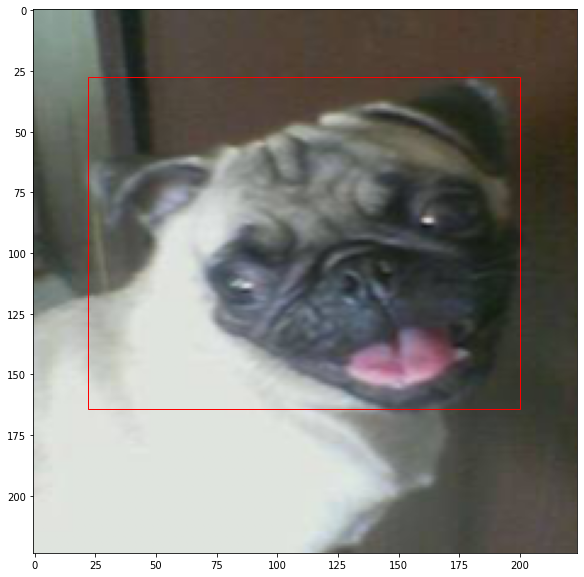

In [ ]:
sample = next(iter(train_loader))
img, label = sample[0][0], sample[1][0]

rect = Rectangle((label[0] * IMG_SIZE, label[1] * IMG_SIZE), label[2] * IMG_SIZE, label[3] * IMG_SIZE, fill=False, color='red')
plt.figure(figsize=(10, 10))
plt.axes().add_patch(rect)
plt.imshow(img)
plt.show()

# Define IOU & Pretrained model(MobileNetV2)

In [ ]:
def iou(bbox_preds, bbox_targets):
    xmin = bbox_targets[..., 0:1]
    ymin = bbox_targets[..., 1:2]
    xmax = bbox_targets[..., 2:3] + xmin
    ymax = bbox_targets[..., 3:4] + ymin

    pred_xmin = bbox_preds[..., 0:1]
    pred_ymin = bbox_preds[..., 1:2]
    pred_xmax = bbox_preds[..., 2:3] + pred_xmin
    pred_ymax = bbox_preds[..., 3:4] + pred_ymin

    union_w = tf.maximum(xmax, pred_xmax) - tf.minimum(xmin, pred_xmin)
    union_h = tf.maximum(ymax, pred_ymax) - tf.minimum(ymin, pred_ymin)
    inter_w = tf.minimum(xmax, pred_xmax) - tf.maximum(xmin, pred_xmin)
    inter_h = tf.minimum(ymax, pred_ymax) - tf.maximum(ymin, pred_ymin)

    sub1_w = tf.abs(xmax - pred_xmax)
    sub1_h = tf.abs(ymin - pred_ymin)
    sub2_w = tf.abs(xmin - pred_xmin)
    sub2_h = tf.abs(ymax - pred_ymax)

    iou = (inter_w * inter_h) / ((union_w * union_h) - (sub1_w * sub1_h) - (sub2_w * sub2_h))
    return iou

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

def mobilenetv2():
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = mobilenet(inputs)
    x = GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    outputs = tf.keras.layers.Dense(4, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Define Model & Loss & Optimizer

In [ ]:
epochs = 20
lr=1e-3
model = mobilenetv2()
model.summary()
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[iou]
)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 tf.math.reduce_mean_14 (TFO  (None, 1280)             0         
 pLambda)                                                        
                                                                 
 dense_38 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_26 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                          

# Training

In [ ]:
hist = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs
)

Epoch 1/20
207/207 [==============================] - 26s 103ms/step - loss: 0.0097 - iou: 0.5032 - val_loss: 0.1281 - val_iou: 0.2772
Epoch 2/20
207/207 [==============================] - 21s 100ms/step - loss: 0.0041 - iou: 0.6199 - val_loss: 0.0567 - val_iou: 0.3750
Epoch 3/20
207/207 [==============================] - 21s 100ms/step - loss: 0.0035 - iou: 0.6407 - val_loss: 0.0229 - val_iou: 0.4662
Epoch 4/20
207/207 [==============================] - 21s 100ms/step - loss: 0.0031 - iou: 0.6530 - val_loss: 0.0115 - val_iou: 0.5276
Epoch 5/20
207/207 [==============================] - 21s 100ms/step - loss: 0.0029 - iou: 0.6616 - val_loss: 0.0094 - val_iou: 0.5545
Epoch 6/20
207/207 [==============================] - 21s 101ms/step - loss: 0.0026 - iou: 0.6738 - val_loss: 0.0044 - val_iou: 0.6410
Epoch 7/20
207/207 [==============================] - 22s 103ms/step - loss: 0.0024 - iou: 0.6834 - val_loss: 0.0032 - val_iou: 0.6770
Epoch 8/20
207/207 [==============================] - 2

# Visualization Loss & IOU

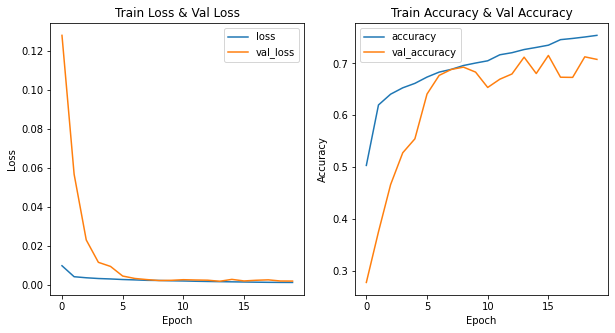

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Train Loss & Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(hist.history['iou'], label='accuracy')
plt.plot(hist.history['val_iou'], label='val_accuracy')
plt.legend(loc='best')
plt.title('Train Accuracy & Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


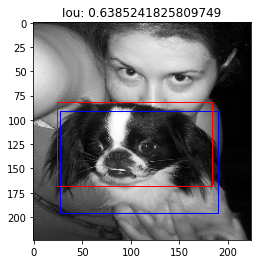

In [ ]:
img , label = next(iter(val_loader))
img, label = img[0:1], label[0]

pred = model.predict(img)
pred = np.reshape(pred, (4))
pred_rect = Rectangle((pred[0] * IMG_SIZE, pred[1] * IMG_SIZE), pred[2] * IMG_SIZE, pred[3] * IMG_SIZE, fill=False, color='blue')
rect = Rectangle((label[0] * IMG_SIZE, label[1] * IMG_SIZE), label[2] * IMG_SIZE, label[3] * IMG_SIZE, fill=False, color='red')
plt.axes().add_patch(pred_rect)
plt.axes().add_patch(rect)
plt.imshow(img[0])
plt.title('Iou: ' + str(iou(label, pred).numpy()[0]))
plt.show()